<h1>GOAL</h1>

We are trying to model a yugioh card's price depending on its attributes. Price here is being used as a stand in for metagame relevance

<h1>HYPOTHESES</h1>


I believe that a card's price is mostly tied to:
* Effect text
* Card supertype (Monster, Spell, Trap)
* Rarity
* Number of printings
* Banlist info

This means that when it comes time to feature selection I will be omitting:
* Name
* Type
* Attribute
* ATK/DEF
* etc...

Things like archetype are debatable, it will worsen the generalisation of the model for new archetypes or unarchetypal cards, but it will improve it for new support. Perhaps two seperate models should be trained. This can be cleared up during exploratory analysis.

NOTE: When preprocessing, it is important to remember that the raw data is organized by card, not by printing. I will have to reformat them before doing exploratory analysis

<h1>POSSIBLE ENRICHMENTS</h1>

If we find that the data present is not enough to predict price, we can scrape tournament results to enrich the data (very time consuming).

We would also have to create some formula which can summarize a cards viability depending on how many times it appears in winning decks, how many copies played, etc.

A list of "yugioh stop words" would be helpful for the NLP

In [1]:
import tensorflow as tf

2025-12-16 11:03:09.643526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765879389.724790  149085 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765879389.748167  149085 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765879389.933211  149085 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765879389.933291  149085 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765879389.933293  149085 computation_placer.cc:177] computation placer alr

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Aquire fresh data
run and save locally, skip most of the time

#just change cell to code

url = "https://db.ygoprodeck.com/api/v7/cardinfo.php?tcgplayer_data"
data_directory_path = "./resultingdata"

response = requests.get(url)
if response.status_code == 200:
    data = response.json() 

else:
    print(f"Request failed with status code: {response.status_code}")

with open('ygoprodeck_api_data.json', 'w') as f:
    json.dump(data['data'], f)

# Load data from local
as to not make extra calls on the poor folks over at ygoprodeck who provide this wonderful api for free

In [4]:
with open("ygoprodeck_api_data.json", 'r') as f:
    raw_data = json.load(f)


# Data Reformatting for Analysis
Clearing up some stuff i definitely wont need, looking at some things i am curious about, and reformatting data to be organized by printing, not by card id.

In [5]:
df_raw = pd.DataFrame(raw_data)

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13757 entries, 0 to 13756
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     13757 non-null  int64  
 1   name                   13757 non-null  object 
 2   type                   13757 non-null  object 
 3   humanReadableCardType  13757 non-null  object 
 4   frameType              13757 non-null  object 
 5   desc                   13757 non-null  object 
 6   race                   13757 non-null  object 
 7   archetype              8187 non-null   object 
 8   ygoprodeck_url         13757 non-null  object 
 9   card_sets              13368 non-null  object 
 10  card_images            13757 non-null  object 
 11  card_prices            13757 non-null  object 
 12  typeline               8839 non-null   object 
 13  atk                    8839 non-null   float64
 14  def                    8407 non-null   float64
 15  le

Here is the list of columns that I will remove immediately because they are useless in exploratory analysis:
* ygoprodeck_url
* card_images
* card_prices (this is a redundant value, we will be using a price value associated with the set and rarity found within card_sets)

In [7]:
columns_to_drop = ['ygoprodeck_url', 'card_images', 'card_prices']
df_raw.drop(columns= columns_to_drop, inplace= True)

In [8]:
df_raw.head(3)

,id,name,type,humanReadableCardType,frameType,desc,race,archetype,card_sets,typeline,atk,def,level,attribute,linkval,linkmarkers,pend_desc,monster_desc,scale,banlist_info
0,34541863,"""A"" Cell Breeding Device",Spell Card,Continuous Spell,spell,"During each of your Standby Phases, put 1 A-Co...",Continuous,Alien,"[{'set_name': 'Force of the Breaker', 'set_cod...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,64163367,"""A"" Cell Incubator",Spell Card,Continuous Spell,spell,Each time an A-Counter(s) is removed from play...,Continuous,Alien,"[{'set_name': 'Gladiator's Assault', 'set_code...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,91231901,"""A"" Cell Recombination Device",Spell Card,Quick-Play Spell,spell,Target 1 face-up monster on the field; send 1 ...,Quick-Play,Alien,"[{'set_name': 'Invasion: Vengeance', 'set_code...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_raw['type'].value_counts()

type
Effect Monster                     4876
Spell Card                         2701
Trap Card                          1987
Normal Monster                      668
XYZ Monster                         553
Fusion Monster                      513
Tuner Monster                       479
Link Monster                        434
Synchro Monster                     432
Pendulum Effect Monster             275
Flip Effect Monster                 188
Skill Card                          124
Ritual Effect Monster               122
Token                               106
Synchro Tuner Monster                50
Gemini Monster                       45
Union Effect Monster                 39
Spirit Monster                       37
Pendulum Normal Monster              35
Toon Monster                         17
Ritual Monster                       15
Pendulum Tuner Effect Monster        14
Normal Tuner Monster                 12
Pendulum Effect Fusion Monster       12
XYZ Pendulum Effect Monster        

In [10]:
df_raw[df_raw['type'] == "Flip Tuner Effect Monster"]

,id,name,type,humanReadableCardType,frameType,desc,race,archetype,card_sets,typeline,atk,def,level,attribute,linkval,linkmarkers,pend_desc,monster_desc,scale,banlist_info
10521,37445295,Shaddoll Falco,Flip Tuner Effect Monster,Flip Tuner Effect Monster,effect,"FLIP: You can target 1 ""Shaddoll"" monster in y...",Spellcaster,Shaddoll,"[{'set_name': '2015 Mega-Tin Mega Pack', 'set_...","[Spellcaster, Flip, Tuner, Effect]",600.0,1400.0,2.0,DARK,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_raw[df_raw['name'] == "Scapeghost"]

,id,name,type,humanReadableCardType,frameType,desc,race,archetype,card_sets,typeline,atk,def,level,attribute,linkval,linkmarkers,pend_desc,monster_desc,scale,banlist_info
10337,67284107,Scapeghost,Tuner Monster,Tuner Effect Monster,effect,"FLIP: You can Special Summon any number of ""Bl...",Zombie,NaN,"[{'set_name': '2017 Mega-Tin Mega Pack', 'set_...","[Zombie, Tuner, Effect]",0.0,0.0,1.0,DARK,NaN,NaN,NaN,NaN,NaN,NaN


Scapeghost and Turbo-Tainted Hot Rod GT19 are also Flip Tuner Effect Monsters

In [12]:
df_raw[df_raw['type'] == "Pendulum Flip Effect Monster"]

,id,name,type,humanReadableCardType,frameType,desc,race,archetype,card_sets,typeline,atk,def,level,attribute,linkval,linkmarkers,pend_desc,monster_desc,scale,banlist_info
8973,20281581,Performapal Momoncarpet,Pendulum Flip Effect Monster,Pendulum Flip Effect Monster,effect_pendulum,[ Pendulum Effect ] \nUnless you have a card i...,Beast,Performapal,"[{'set_name': 'Starter Deck: Yuya', 'set_code'...","[Beast, Pendulum, Flip, Effect]",1000.0,100.0,3.0,EARTH,NaN,NaN,Unless you have a card in your other Pendulum ...,FLIP: You can target 1 Set card on the field; ...,7.0,NaN


This is the only Pendulum flip monster!

Data Reshaping (exploding card_sets column)

In [13]:
df_exploded = df_raw.explode('card_sets').reset_index(drop= True)
card_sets_df = pd.json_normalize(df_exploded['card_sets'])
df_raw_by_printing = pd.concat([df_exploded.drop(columns='card_sets'), card_sets_df], axis=1)


In [14]:
df_exploded[df_exploded['id'] == 88504133]

,id,name,type,humanReadableCardType,frameType,desc,race,archetype,card_sets,typeline,atk,def,level,attribute,linkval,linkmarkers,pend_desc,monster_desc,scale,banlist_info
38245,88504133,Phantom Knights' Rank-Up-Magic Force,Spell Card,Quick-Play Spell,spell,During the Main Phase: Banish 1 or more DARK m...,Quick-Play,Phantom Knights,"{'set_name': '2021 Tin of Ancient Battles', 's...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38246,88504133,Phantom Knights' Rank-Up-Magic Force,Spell Card,Quick-Play Spell,spell,During the Main Phase: Banish 1 or more DARK m...,Quick-Play,Phantom Knights,"{'set_name': 'Phantom Rage', 'set_code': 'PHRA...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
card_sets_df

,set_name,set_code,set_rarity,set_rarity_code,set_edition,set_price,set_url
0,Force of the Breaker,FOTB-EN043,Common,(C),Unlimited,0.15,https://partner.tcgplayer.com/c/5616751/183015...
1,Force of the Breaker,FOTB-EN043,Common,(C),1st Edition,0.24,https://partner.tcgplayer.com/c/5616751/183015...
2,Gladiator's Assault,GLAS-EN062,Common,(C),Unlimited,0.15,https://partner.tcgplayer.com/c/5616751/183015...
3,Gladiator's Assault,GLAS-EN062,Common,(C),1st Edition,0.25,https://partner.tcgplayer.com/c/5616751/183015...
4,Invasion: Vengeance,INOV-EN063,Common,(C),Unlimited,0.26,https://partner.tcgplayer.com/c/5616751/183015...
...,...,...,...,...,...,...,...
56919,Order of Chaos,ORCS-EN005,Rare,(R),Unlimited,0.16,https://partner.tcgplayer.com/c/5616751/183015...
56920,Order of Chaos,ORCS-EN005,Rare,(R),1st Edition,0.20,https://partner.tcgplayer.com/c/5616751/183015...
56921,Star Pack 2014,SP14-EN004,Common,(C),1st Edition,0.23,https://partner.tcgplayer.com/c/5616751/183015...
56922,Star Pack 2014,SP14-EN004,Starfoil Rare,(SFR),1st Edition,0.59,https://partner.tcgplayer.com/c/5616751/183015...


In [16]:
df_exploded['name'].value_counts().head()

name
Blue-Eyes White Dragon    124
Dark Magician             103
Mystical Space Typhoon     93
Polymerization             84
Call of the Haunted        79
Name: count, dtype: int64

In [17]:
df_raw_by_printing

,id,name,type,humanReadableCardType,frameType,desc,race,archetype,typeline,atk,...,monster_desc,scale,banlist_info,set_name,set_code,set_rarity,set_rarity_code,set_edition,set_price,set_url
0,34541863,"""A"" Cell Breeding Device",Spell Card,Continuous Spell,spell,"During each of your Standby Phases, put 1 A-Co...",Continuous,Alien,NaN,NaN,...,NaN,NaN,NaN,Force of the Breaker,FOTB-EN043,Common,(C),Unlimited,0.15,https://partner.tcgplayer.com/c/5616751/183015...
1,34541863,"""A"" Cell Breeding Device",Spell Card,Continuous Spell,spell,"During each of your Standby Phases, put 1 A-Co...",Continuous,Alien,NaN,NaN,...,NaN,NaN,NaN,Force of the Breaker,FOTB-EN043,Common,(C),1st Edition,0.24,https://partner.tcgplayer.com/c/5616751/183015...
2,64163367,"""A"" Cell Incubator",Spell Card,Continuous Spell,spell,Each time an A-Counter(s) is removed from play...,Continuous,Alien,NaN,NaN,...,NaN,NaN,NaN,Gladiator's Assault,GLAS-EN062,Common,(C),Unlimited,0.15,https://partner.tcgplayer.com/c/5616751/183015...
3,64163367,"""A"" Cell Incubator",Spell Card,Continuous Spell,spell,Each time an A-Counter(s) is removed from play...,Continuous,Alien,NaN,NaN,...,NaN,NaN,NaN,Gladiator's Assault,GLAS-EN062,Common,(C),1st Edition,0.25,https://partner.tcgplayer.com/c/5616751/183015...
4,91231901,"""A"" Cell Recombination Device",Spell Card,Quick-Play Spell,spell,Target 1 face-up monster on the field; send 1 ...,Quick-Play,Alien,NaN,NaN,...,NaN,NaN,NaN,Invasion: Vengeance,INOV-EN063,Common,(C),Unlimited,0.26,https://partner.tcgplayer.com/c/5616751/183015...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56919,76080032,ZW - Unicorn Spear,Effect Monster,Effect Monster,effect,"You can target 1 ""Number C39: Utopia Ray"" you ...",Beast,Utopia,"[Beast, Effect]",1900.0,...,NaN,NaN,NaN,Order of Chaos,ORCS-EN005,Rare,(R),Unlimited,0.16,https://partner.tcgplayer.com/c/5616751/183015...
56920,76080032,ZW - Unicorn Spear,Effect Monster,Effect Monster,effect,"You can target 1 ""Number C39: Utopia Ray"" you ...",Beast,Utopia,"[Beast, Effect]",1900.0,...,NaN,NaN,NaN,Order of Chaos,ORCS-EN005,Rare,(R),1st Edition,0.20,https://partner.tcgplayer.com/c/5616751/183015...
56921,76080032,ZW - Unicorn Spear,Effect Monster,Effect Monster,effect,"You can target 1 ""Number C39: Utopia Ray"" you ...",Beast,Utopia,"[Beast, Effect]",1900.0,...,NaN,NaN,NaN,Star Pack 2014,SP14-EN004,Common,(C),1st Edition,0.23,https://partner.tcgplayer.com/c/5616751/183015...
56922,76080032,ZW - Unicorn Spear,Effect Monster,Effect Monster,effect,"You can target 1 ""Number C39: Utopia Ray"" you ...",Beast,Utopia,"[Beast, Effect]",1900.0,...,NaN,NaN,NaN,Star Pack 2014,SP14-EN004,Starfoil Rare,(SFR),1st Edition,0.59,https://partner.tcgplayer.com/c/5616751/183015...


In [18]:
len(df_raw_by_printing)

56924

In [19]:
df_raw_by_printing.dtypes

id                         int64
name                      object
type                      object
humanReadableCardType     object
frameType                 object
desc                      object
race                      object
archetype                 object
typeline                  object
atk                      float64
def                      float64
level                    float64
attribute                 object
linkval                  float64
linkmarkers               object
pend_desc                 object
monster_desc              object
scale                    float64
banlist_info              object
set_name                  object
set_code                  object
set_rarity                object
set_rarity_code           object
set_edition               object
set_price                 object
set_url                   object
dtype: object

# Exploratory Analysis

I'm going to first add columns which are the max and min price of the card, so I can take price averages without having to worry about the number of printings.

I will also add a num printings column to aid in the exploratory analysis and because it is a feature I am considering using for the model.

I'm going to drop set_url, its not useful for analysis

In [20]:
df_raw_by_printing.drop(columns= ['set_url'], inplace= True)

In [21]:
# mapping num printings
df_raw_by_printing['num_prints'] = df_raw_by_printing['id'].map(df_raw_by_printing['id'].value_counts())

In [22]:
df_raw_by_printing['set_price'] = pd.to_numeric(df_raw_by_printing['set_price'], errors='coerce')

df_raw_by_printing['max_price'] = df_raw_by_printing.groupby('id')['set_price'].transform('max')
df_raw_by_printing['min_price'] = df_raw_by_printing.groupby('id')['set_price'].transform('min')

In [23]:
len(df_raw_by_printing[df_raw_by_printing['max_price'].isna()])

389

In [24]:
len(df_raw_by_printing[df_raw_by_printing['set_price'].isna()])

396

In [25]:
df_raw_by_printing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56924 entries, 0 to 56923
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     56924 non-null  int64  
 1   name                   56924 non-null  object 
 2   type                   56924 non-null  object 
 3   humanReadableCardType  56924 non-null  object 
 4   frameType              56924 non-null  object 
 5   desc                   56924 non-null  object 
 6   race                   56924 non-null  object 
 7   archetype              30823 non-null  object 
 8   typeline               36233 non-null  object 
 9   atk                    36233 non-null  float64
 10  def                    34874 non-null  float64
 11  level                  35299 non-null  float64
 12  attribute              36233 non-null  object 
 13  linkval                1362 non-null   float64
 14  linkmarkers            1362 non-null   object 
 15  pe

In [26]:
df_raw_by_printing['frameType'].value_counts()

frameType
effect              24208
spell               12159
trap                 8272
normal               3107
fusion               2172
xyz                  2091
synchro              1822
link                 1362
effect_pendulum       799
ritual                478
skill                 147
normal_pendulum       130
token                 113
fusion_pendulum        26
xyz_pendulum           22
synchro_pendulum       11
ritual_pendulum         5
Name: count, dtype: int64

In [27]:
avg_price_by_archetype = df_raw_by_printing.groupby('archetype')['set_price'].mean().sort_values(ascending= False)
min_avg_price_by_archetype = df_raw_by_printing.groupby('archetype')['min_price'].mean().sort_values(ascending= False)

In [28]:
print(avg_price_by_archetype['Snake-Eye'], min_avg_price_by_archetype['Snake-Eye'])

6.691333333333334 1.2926666666666666


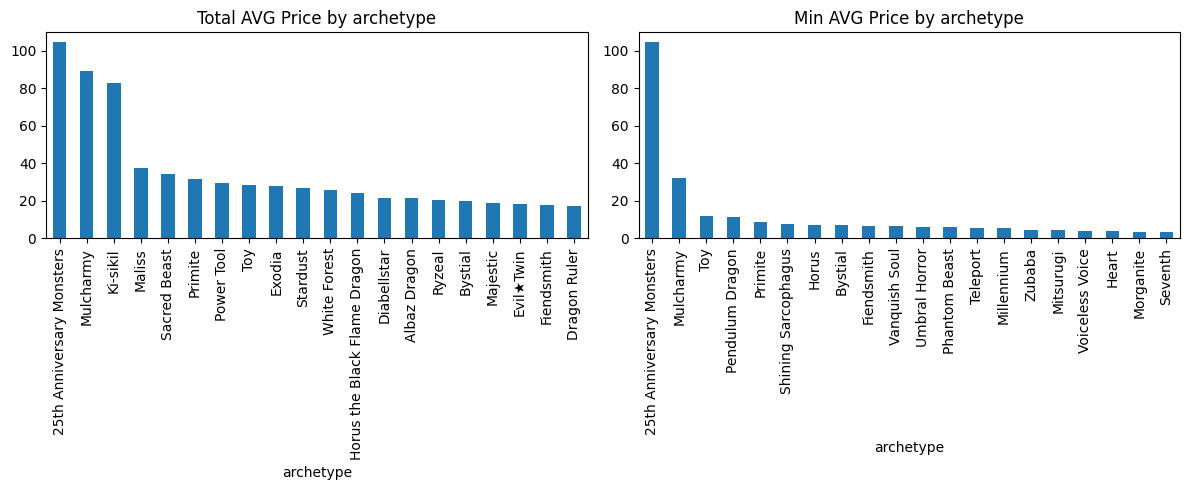

In [29]:
fig, axes = plt.subplots(1,2, figsize=(12, 5))
avg_price_by_archetype.head(20).plot.bar(ax= axes[0])
axes[0].set_title("Total AVG Price by archetype")
min_avg_price_by_archetype.head(20).plot.bar(ax= axes[1])
axes[1].set_title("Min AVG Price by archetype")


plt.tight_layout()
plt.show()


In [30]:
df_raw_by_printing[df_raw_by_printing['archetype'] == "25th Anniversary Monsters"]

,id,name,type,humanReadableCardType,frameType,desc,race,archetype,typeline,atk,...,banlist_info,set_name,set_code,set_rarity,set_rarity_code,set_edition,set_price,num_prints,max_price,min_price
14734,58931850,Dragon Master Lords,XYZ Monster,Xyz Effect Monster,xyz,2 Level 12 monsters\r\nWhile this Xyz Summoned...,Dragon,25th Anniversary Monsters,"[Dragon, Xyz, Effect]",5000.0,...,NaN,Alliance Insight,ALIN-EN000,Quarter Century Secret Rare,,1st Edition,109.75,1,109.75,109.75
37370,99217226,Paladins of Bonds and Unity,Synchro Monster,Synchro Effect Monster,synchro,1 Tuner + 1+ non-Tuner monsters with 2500 orig...,Spellcaster,25th Anniversary Monsters,"[Spellcaster, Synchro, Effect]",2900.0,...,NaN,Supreme Darkness,SUDA-EN000,Quarter Century Secret Rare,,1st Edition,99.46,1,99.46,99.46


In [31]:
df_raw_by_printing[df_raw_by_printing['archetype'] == "Toy"].sort_values('set_price', ascending=False)

,id,name,type,humanReadableCardType,frameType,desc,race,archetype,typeline,atk,...,banlist_info,set_name,set_code,set_rarity,set_rarity_code,set_edition,set_price,num_prints,max_price,min_price
49658,49299410,The Black Goat Laughs,Trap Card,Normal Trap,trap,"Declare 1 Monster Card name; this turn, neithe...",Normal,Toy,NaN,NaN,...,NaN,Phantom Nightmare,PHNI-EN078,Quarter Century Secret Rare,,1st Edition,111.41,2,111.41,29.81
49657,49299410,The Black Goat Laughs,Trap Card,Normal Trap,trap,"Declare 1 Monster Card name; this turn, neithe...",Normal,Toy,NaN,NaN,...,NaN,Phantom Nightmare,PHNI-EN078,Secret Rare,(ScR),1st Edition,29.81,2,111.41,29.81
51774,24878656,Toy Box,Spell Card,Continuous Spell,spell,"Once per turn, when an opponent's monster decl...",Continuous,Toy,NaN,NaN,...,NaN,Battles of Legend: Terminal Revenge,BLTR-EN023,Ultra Rare,(UR),1st Edition,0.62,1,0.62,0.62
51782,65504487,Toy Soldier,Effect Monster,Effect Monster,effect,You can Set this card from your hand to your S...,Warrior,Toy,"[Warrior, Effect]",1500.0,...,NaN,Battles of Legend: Terminal Revenge,BLTR-EN021,Ultra Rare,(UR),1st Edition,0.31,1,0.31,0.31
51783,69925461,Toy Tank,Effect Monster,Effect Monster,effect,You can Set this card from your hand to your S...,Machine,Toy,"[Machine, Effect]",1000.0,...,NaN,Battles of Legend: Terminal Revenge,BLTR-EN022,Ultra Rare,(UR),1st Edition,0.24,1,0.24,0.24


<Axes: xlabel='set_rarity'>

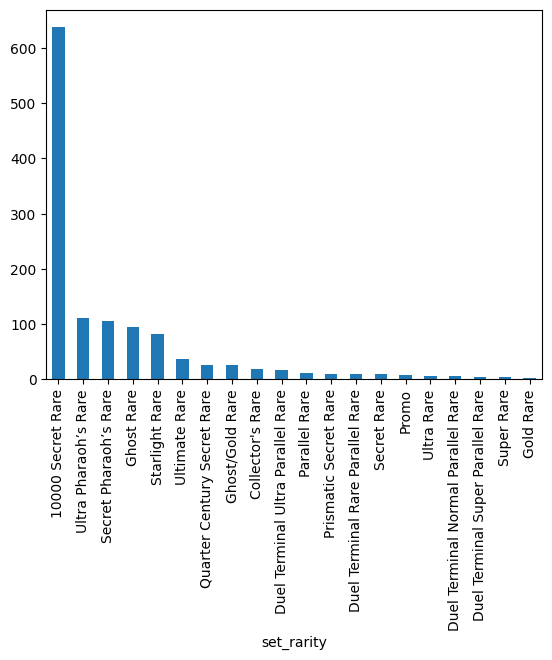

In [32]:

df_raw_by_printing.groupby('set_rarity')['set_price'].mean().sort_values(ascending= False).head(20).plot.bar()

In [33]:
df_raw_by_printing['set_rarity'].value_counts().sort_values(ascending= False)

set_rarity
Common                                 25102
Super Rare                              6792
Ultra Rare                              6736
Rare                                    6294
Secret Rare                             3668
Ultimate Rare                           1345
Quarter Century Secret Rare             1088
Platinum Secret Rare                     724
Starfoil Rare                            711
Gold Rare                                515
Duel Terminal Normal Parallel Rare       446
Mosaic Rare                              430
Prismatic Secret Rare                    416
Prismatic Ultimate Rare                  323
Prismatic Collector's Rare               323
Shatterfoil Rare                         297
Collector's Rare                         215
Gold Secret Rare                         151
Duel Terminal Rare Parallel Rare         143
Duel Terminal Technology Common          139
Premium Gold Rare                        123
Starlight Rare                           123

set_price    Axes(0.125,0.11;0.775x0.77)
dtype: object

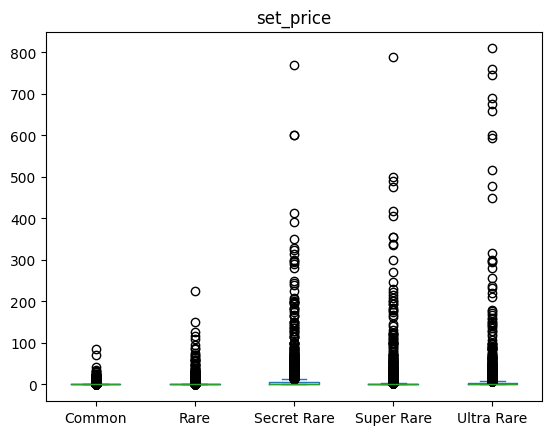

In [34]:
df_raw_by_printing[df_raw_by_printing['set_rarity'].isin(["Common", "Super Rare", "Ultra Rare", "Rare", "Secret Rare"])].plot.box(column= 'set_price', by='set_rarity')

We can see from these distributions of the most present rarities that there are more examples of especially expensive cards at higher rarities. These outliers that we see are probably the data that I am interested in, it might be a good idea to cut a lot of the habitual examples (pack filler).

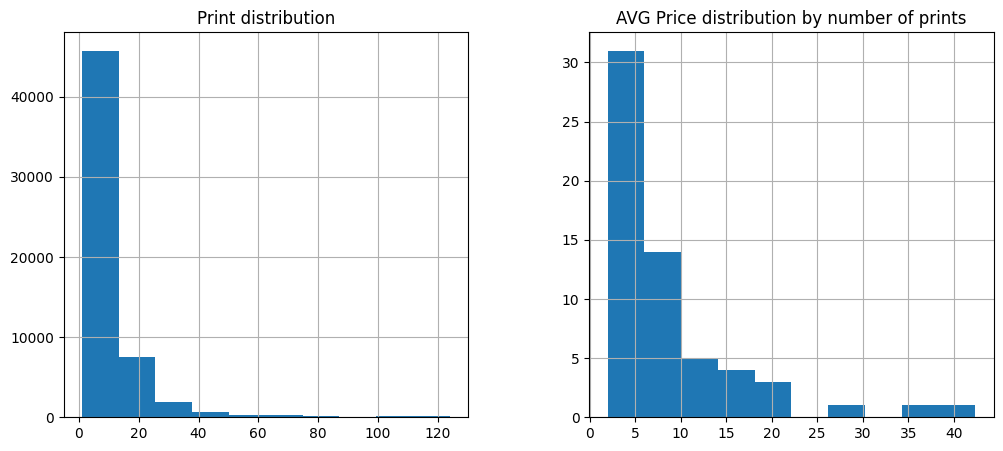

In [35]:
fig, axes = plt.subplots(1,2, figsize=(12, 5))

df_raw_by_printing.hist(column='num_prints', ax= axes[0])
axes[0].set_title("Print distribution")
df_raw_by_printing.groupby('num_prints')['set_price'].mean().hist(ax= axes[1])
axes[1].set_title("AVG Price distribution by number of prints")
plt.show()

The number of printings definitely seems to have an effect on price, intuitivley the more a card is printed the less expensive all other copies of that card will be because it is easier to get ahold of. Cards will always have the same text and number of printings but the time a card is printed is shared by many different cards (e.g. there are many cards which have been printed only 3 times). It is possible that the number of printings and rarity alone is enough to model the price over the lifespan of the entire game.

I want to factor in metagame relevance via card text so it might be more relevant to look at more recent releases in the past couple of years only in order to get rid of a bunch of cards that simply exist but are not played. That being said number of prints should be calculated over the entire game's lifetime because it still affects the price of cards today. Edition is another factor I won't have to worry about if I only focus on recent cards.

In [36]:
# most printed cards just for fun
df_raw_by_printing[['name','num_prints']].drop_duplicates().sort_values('num_prints', ascending= False).head(20)

,name,num_prints
5484,Blue-Eyes White Dragon,124
11816,Dark Magician,103
34384,Mystical Space Typhoon,93
38678,Polymerization,84
6855,Call of the Haunted,79
48689,Swords of Revealing Light,74
11919,Dark Magician Girl,71
33653,Monster Reborn,70
9973,Cyber Dragon,64
33244,Mirror Force,62


In [37]:
df_raw_by_printing['banlist_info'].value_counts()

banlist_info
{'ban_goat': 'Limited'}                                                         844
{'ban_tcg': 'Limited', 'ban_ocg': 'Limited'}                                    385
{'ban_tcg': 'Forbidden', 'ban_ocg': 'Forbidden'}                                331
{'ban_tcg': 'Limited'}                                                          224
{'ban_goat': 'Semi-Limited'}                                                    200
{'ban_tcg': 'Limited', 'ban_ocg': 'Limited', 'ban_goat': 'Limited'}             157
{'ban_ocg': 'Limited'}                                                          155
{'ban_tcg': 'Forbidden'}                                                        149
{'ban_goat': 'Forbidden'}                                                       125
{'ban_ocg': 'Semi-Limited'}                                                     118
{'ban_tcg': 'Forbidden', 'ban_ocg': 'Forbidden', 'ban_goat': 'Limited'}          98
{'ban_tcg': 'Limited', 'ban_ocg': 'Limited', 'ban_goat': 'Forbi

In [38]:
# we are going to assume that price is ONLY driven by tcg format to simplify the model

def extract_tcg_status(banlist_info):
    if banlist_info is np.nan:
        return 3
    
    if "ban_tcg" not in banlist_info.keys():
        return 3
    
    map = {'Forbidden': 0,
           'Limited': 1,
           'Semi-Limited': 2}
    
    return map[banlist_info['ban_tcg']]

df_raw_by_printing['allowed_copies'] = df_raw_by_printing['banlist_info'].apply(extract_tcg_status)

In [39]:
df_raw_by_printing['allowed_copies'].value_counts()

allowed_copies
3    55122
1      991
0      713
2       98
Name: count, dtype: int64

In [40]:
# dropping ts its now redundant
df_raw_by_printing.drop(columns= 'banlist_info', inplace= True)

0         Axes(0.1,0.559091;0.363636x0.340909)
1    Axes(0.536364,0.559091;0.363636x0.340909)
2             Axes(0.1,0.15;0.363636x0.340909)
3        Axes(0.536364,0.15;0.363636x0.340909)
dtype: object

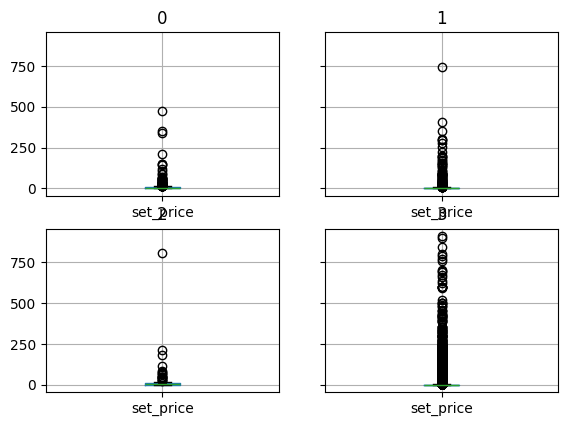

In [41]:
groupby_banlist = df_raw_by_printing.groupby('allowed_copies')
groupby_banlist.boxplot(column='set_price')

1st Edition         Axes(0.1,0.559091;0.363636x0.340909)
Limited        Axes(0.536364,0.559091;0.363636x0.340909)
Unlimited               Axes(0.1,0.15;0.363636x0.340909)
dtype: object

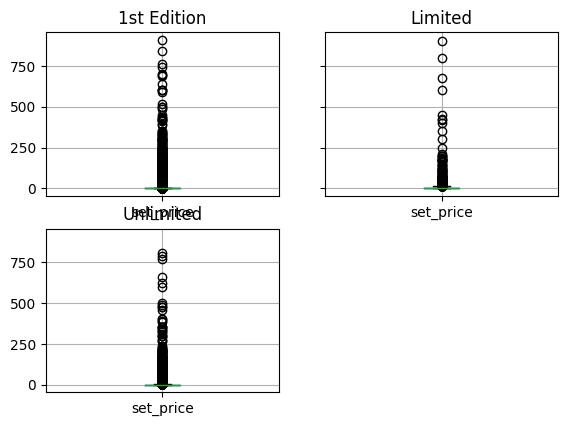

In [42]:
groupby_edition = df_raw_by_printing.groupby('set_edition')
groupby_edition.boxplot(column='set_price')

In [43]:
df_raw_by_printing['set_code'].value_counts()

set_code
RA02-EN001    15
RA01-EN019    14
RA03-EN056    14
RA02-EN006    14
RA01-EN043    14
              ..
DB1-EN198      1
DR2-EN183      1
NECH-ENS10     1
MP24-EN038     1
MP15-EN169     1
Name: count, Length: 35311, dtype: int64

In [44]:
df_raw_by_printing['set_name'].value_counts()

set_name
Quarter Century Stampede            975
Quarter Century Bonanza             968
Battle Pack: Epic Dawn              880
Battle Pack 2: War of the Giants    854
Duelist League Promo                734
                                   ... 
World Championship 2008 DS Game       1
Samurai Assault                       1
Ultimate Edition 2                    1
Sneak Preview Series 4                1
Fire Fists Special Editon             1
Name: count, Length: 603, dtype: int64

In [45]:
df_raw_by_printing['frameType'].value_counts()

frameType
effect              24208
spell               12159
trap                 8272
normal               3107
fusion               2172
xyz                  2091
synchro              1822
link                 1362
effect_pendulum       799
ritual                478
skill                 147
normal_pendulum       130
token                 113
fusion_pendulum        26
xyz_pendulum           22
synchro_pendulum       11
ritual_pendulum         5
Name: count, dtype: int64

In [46]:
print(df_raw_by_printing[df_raw_by_printing['pend_desc'].notna()]['desc'].iat[0])

[ Pendulum Effect ] 
You can target 1 "Abyss Actor" Pendulum Monster you control and 1 monster your opponent controls; switch control of both monsters, then destroy this card. You can only use this effect of "Abyss Actor - Comic Relief" once per turn.

[ Monster Effect ] 
You take no battle damage from attacks involving this card. Once per turn, during your Standby Phase: Give control of this card to your opponent. Once per turn, if control of this face-up card changes: Activate this effect; the owner of this card can destroy 1 Set "Abyss Script" Spell in their Spell & Trap Zone.


# Feature selection and preprocessing

In [47]:
df_raw_by_printing.head()

,id,name,type,humanReadableCardType,frameType,desc,race,archetype,typeline,atk,...,set_name,set_code,set_rarity,set_rarity_code,set_edition,set_price,num_prints,max_price,min_price,allowed_copies
0,34541863,"""A"" Cell Breeding Device",Spell Card,Continuous Spell,spell,"During each of your Standby Phases, put 1 A-Co...",Continuous,Alien,NaN,NaN,...,Force of the Breaker,FOTB-EN043,Common,(C),Unlimited,0.15,2,0.24,0.15,3
1,34541863,"""A"" Cell Breeding Device",Spell Card,Continuous Spell,spell,"During each of your Standby Phases, put 1 A-Co...",Continuous,Alien,NaN,NaN,...,Force of the Breaker,FOTB-EN043,Common,(C),1st Edition,0.24,2,0.24,0.15,3
2,64163367,"""A"" Cell Incubator",Spell Card,Continuous Spell,spell,Each time an A-Counter(s) is removed from play...,Continuous,Alien,NaN,NaN,...,Gladiator's Assault,GLAS-EN062,Common,(C),Unlimited,0.15,2,0.25,0.15,3
3,64163367,"""A"" Cell Incubator",Spell Card,Continuous Spell,spell,Each time an A-Counter(s) is removed from play...,Continuous,Alien,NaN,NaN,...,Gladiator's Assault,GLAS-EN062,Common,(C),1st Edition,0.25,2,0.25,0.15,3
4,91231901,"""A"" Cell Recombination Device",Spell Card,Quick-Play Spell,spell,Target 1 face-up monster on the field; send 1 ...,Quick-Play,Alien,NaN,NaN,...,Invasion: Vengeance,INOV-EN063,Common,(C),Unlimited,0.26,2,0.27,0.26,3


In [48]:
df_raw_by_printing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56924 entries, 0 to 56923
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     56924 non-null  int64  
 1   name                   56924 non-null  object 
 2   type                   56924 non-null  object 
 3   humanReadableCardType  56924 non-null  object 
 4   frameType              56924 non-null  object 
 5   desc                   56924 non-null  object 
 6   race                   56924 non-null  object 
 7   archetype              30823 non-null  object 
 8   typeline               36233 non-null  object 
 9   atk                    36233 non-null  float64
 10  def                    34874 non-null  float64
 11  level                  35299 non-null  float64
 12  attribute              36233 non-null  object 
 13  linkval                1362 non-null   float64
 14  linkmarkers            1362 non-null   object 
 15  pe

In [49]:
deselected_features = ["id", "name", "type", "humanReadableCardType", "race", "archetype", "typeline", "atk", "def", "level", "attribute", "linkval", "linkmarkers", "pend_desc", "monster_desc", "scale", "set_code", "set_rarity_code", "max_price", "min_price", "set_name"]

In [50]:
df_prep = df_raw_by_printing.copy()
df_prep.head()

,id,name,type,humanReadableCardType,frameType,desc,race,archetype,typeline,atk,...,set_name,set_code,set_rarity,set_rarity_code,set_edition,set_price,num_prints,max_price,min_price,allowed_copies
0,34541863,"""A"" Cell Breeding Device",Spell Card,Continuous Spell,spell,"During each of your Standby Phases, put 1 A-Co...",Continuous,Alien,NaN,NaN,...,Force of the Breaker,FOTB-EN043,Common,(C),Unlimited,0.15,2,0.24,0.15,3
1,34541863,"""A"" Cell Breeding Device",Spell Card,Continuous Spell,spell,"During each of your Standby Phases, put 1 A-Co...",Continuous,Alien,NaN,NaN,...,Force of the Breaker,FOTB-EN043,Common,(C),1st Edition,0.24,2,0.24,0.15,3
2,64163367,"""A"" Cell Incubator",Spell Card,Continuous Spell,spell,Each time an A-Counter(s) is removed from play...,Continuous,Alien,NaN,NaN,...,Gladiator's Assault,GLAS-EN062,Common,(C),Unlimited,0.15,2,0.25,0.15,3
3,64163367,"""A"" Cell Incubator",Spell Card,Continuous Spell,spell,Each time an A-Counter(s) is removed from play...,Continuous,Alien,NaN,NaN,...,Gladiator's Assault,GLAS-EN062,Common,(C),1st Edition,0.25,2,0.25,0.15,3
4,91231901,"""A"" Cell Recombination Device",Spell Card,Quick-Play Spell,spell,Target 1 face-up monster on the field; send 1 ...,Quick-Play,Alien,NaN,NaN,...,Invasion: Vengeance,INOV-EN063,Common,(C),Unlimited,0.26,2,0.27,0.26,3


In [51]:
df_prep.drop(columns= deselected_features, inplace= True)
df_prep.head()

,frameType,desc,set_rarity,set_edition,set_price,num_prints,allowed_copies
0,spell,"During each of your Standby Phases, put 1 A-Co...",Common,Unlimited,0.15,2,3
1,spell,"During each of your Standby Phases, put 1 A-Co...",Common,1st Edition,0.24,2,3
2,spell,Each time an A-Counter(s) is removed from play...,Common,Unlimited,0.15,2,3
3,spell,Each time an A-Counter(s) is removed from play...,Common,1st Edition,0.25,2,3
4,spell,Target 1 face-up monster on the field; send 1 ...,Common,Unlimited,0.26,2,3


In [52]:
len(df_prep[df_prep['frameType'] == "skill"].index)

147

In [53]:
df_prep.drop(index= df_prep[df_prep['frameType'] == "skill"].index, axis= 1, inplace= True)

In [54]:
df_prep.drop(index= df_prep[df_prep['frameType'] == "token"].index, axis= 1, inplace= True)

In [55]:
df_prep.reset_index(drop= True, inplace= True)
df_prep

,frameType,desc,set_rarity,set_edition,set_price,num_prints,allowed_copies
0,spell,"During each of your Standby Phases, put 1 A-Co...",Common,Unlimited,0.15,2,3
1,spell,"During each of your Standby Phases, put 1 A-Co...",Common,1st Edition,0.24,2,3
2,spell,Each time an A-Counter(s) is removed from play...,Common,Unlimited,0.15,2,3
3,spell,Each time an A-Counter(s) is removed from play...,Common,1st Edition,0.25,2,3
4,spell,Target 1 face-up monster on the field; send 1 ...,Common,Unlimited,0.26,2,3
...,...,...,...,...,...,...,...
56659,effect,"You can target 1 ""Number C39: Utopia Ray"" you ...",Rare,Unlimited,0.16,5,3
56660,effect,"You can target 1 ""Number C39: Utopia Ray"" you ...",Rare,1st Edition,0.20,5,3
56661,effect,"You can target 1 ""Number C39: Utopia Ray"" you ...",Common,1st Edition,0.23,5,3
56662,effect,"You can target 1 ""Number C39: Utopia Ray"" you ...",Starfoil Rare,1st Edition,0.59,5,3


In [56]:
df_prep['set_edition'].value_counts()

set_edition
1st Edition    33307
Unlimited      20730
Limited         2331
Name: count, dtype: int64

In [57]:
df_prep['set_edition'].isna().sum()

np.int64(296)

In [58]:
df_prep.dropna(subset=['set_edition'], inplace= True)

In [59]:
df_prep['set_rarity'].isna().sum()

np.int64(0)

In [60]:
df_prep['frameType'].value_counts()

frameType
effect              24153
spell               12133
trap                 8262
normal               2942
fusion               2163
xyz                  2086
synchro              1813
link                 1350
effect_pendulum       797
ritual                476
normal_pendulum       130
fusion_pendulum        25
xyz_pendulum           22
synchro_pendulum       11
ritual_pendulum         5
Name: count, dtype: int64

In [61]:
df_prep['set_price'].mode()

0    0.0
Name: set_price, dtype: float64

In [62]:
df_test_distrib = df_prep[df_prep['set_price'].between(1, 150)]
df_test_distrib.reset_index(inplace= True)
len(df_test_distrib)

15013

<Axes: ylabel='Frequency'>

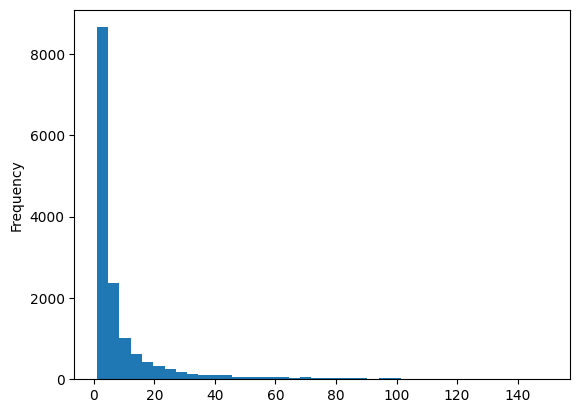

In [63]:
df_test_distrib['set_price'].plot.hist(bins= 40)

In [64]:
df_prep = df_test_distrib

We must split the text from the other metadata. we will use the keras functional API to have two imputs into the model, the text in LSTM networks and the other data in a dense network, ending up in a single neuron with no activation function. god bless Francois Cholet

# Text transformation

I need to treat the operations in a couple of ways, first I will need some info

I will need some info about the average length of a text, to see if I need to restrict the length of the vocab dictionary

In [65]:
from collections import Counter
import re

Two approaches, conserve punctuation to distinguish cost, effect, and condition, or remove it. i will start by removing it all to simplify

In [66]:

def tokenize_effect_text(effect_string):
    result = effect_string.lower()
    # remove names in quotes
    result = re.sub(r' "[^"]+"', "", result)
    # replace apostrophies by nothing
    result = re.sub(r"'", "", result)
    # replace parentheses by nothing
    result = re.sub(r'[()]', "", result)
    # replace other punctuation with a space
    result = re.sub(r'[^\w\s\d]', " ", result)
    # remove additional tags not covered in previous section
    result = re.sub(r'[\r\n]+', '', result)
    # remove double spaces
    result = re.sub(r"\s+", " ", result)
    
    result = result.strip()

    tokens = result.split(" ")
    return tokens
    

In [67]:
df_prep['desc_tokenized'] = df_prep['desc'].apply(tokenize_effect_text)

/tmp/ipykernel_149085/3615674424.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prep['desc_tokenized'] = df_prep['desc'].apply(tokenize_effect_text)


In [68]:
vocab_dict = Counter()

for index, tokens in df_prep['desc_tokenized'].items():
    vocab_dict.update(tokens)

In [69]:
len(vocab_dict)

2315

In [70]:
df_prep['n_words'] = df_prep['desc_tokenized'].apply(len)

/tmp/ipykernel_149085/969396218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prep['n_words'] = df_prep['desc_tokenized'].apply(len)


In [71]:
df_prep['n_words'].describe([.05,.99]).T

count    15013.000000
mean        45.559981
std         26.607290
min          1.000000
5%           9.000000
50%         42.000000
99%        106.000000
max        179.000000
Name: n_words, dtype: float64

In [72]:
max_token_length = 100

# The model

## Definition of the model

There will be 2 data flux

```
Metadata (ATK,DEF,rarity,etc)-\
                               >- NN -> price
Effect Text -> Embeddings ----/
```


In [73]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

### Additional steps for Text Vectorization with Tensorflow

In [74]:
vocab = list(vocab_dict.keys())

In [75]:
def clean_text_for_layer(effect_string):
    x = tf.strings.lower(effect_string)
    x = tf.strings.regex_replace(x, r' "[^"]+"', "")
    x = tf.strings.regex_replace(x, r"'", "")
    x = tf.strings.regex_replace(x, r"[()]", "")
    x = tf.strings.regex_replace(x, r"[^\w\s\d]", "")
    x = tf.strings.regex_replace(x, r"[\r\n]+", "")
    x = tf.strings.regex_replace(x, r"\s+", " ")
    x = tf.strings.strip(x)

    return x

In [76]:
# text processing layer and test
text_vectorizer = layers.TextVectorization(output_mode= "int", output_sequence_length= max_token_length, standardize= clean_text_for_layer, split="whitespace", name= "vectorizer", vocabulary= vocab)
test_text = df_prep['desc'].iat[56]
test_text, text_vectorizer(test_text)

I0000 00:00:1765879402.264102  149085 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


('Special Summon 1 "Mermail" monster from your Deck. Its effects are negated. You cannot activate any Spell Cards. When this card leaves the field, destroy that monster. Destroy this card during your opponent\'s next End Phase after activation.',
 <tf.Tensor: shape=(100,), dtype=int64, numpy=
 array([ 53,  54,  13,   9,  15,  16,  17, 156, 108,  66, 223,  10,  56,
         62, 122,  14,  70,  64,   3,   4, 205,  30,  73,  27,  37,   9,
         27,   3,   4,  63,  16, 155, 224, 111, 104, 225, 169,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0])>)

side note: "Phase" is probably a useless bit of information we can remove from the vocab if we ever make a list of yugioh stop words

### Encoding categorical fields and standardizing numerical ones

In [77]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline

In [78]:
df_prep.head()

,index,frameType,desc,set_rarity,set_edition,set_price,num_prints,allowed_copies,desc_tokenized,n_words
0,10,spell,While this card is equipped to a monster: You ...,Quarter Century Secret Rare,1st Edition,8.31,2,3,"[while, this, card, is, equipped, to, a, monst...",87
1,13,spell,While this card is equipped to a monster: You ...,Ultra Rare,1st Edition,3.77,3,3,"[while, this, card, is, equipped, to, a, monst...",94
2,18,spell,If you control no monsters: Special Summon 1 L...,Super Rare,1st Edition,3.88,5,3,"[if, you, control, no, monsters, special, summ...",39
3,20,spell,If you control no monsters: Special Summon 1 L...,Super Rare,Unlimited,3.49,5,3,"[if, you, control, no, monsters, special, summ...",39
4,21,spell,If you control no monsters: Special Summon 1 L...,Super Rare,1st Edition,3.72,5,3,"[if, you, control, no, monsters, special, summ...",39


In [79]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15013 entries, 0 to 15012
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           15013 non-null  int64  
 1   frameType       15013 non-null  object 
 2   desc            15013 non-null  object 
 3   set_rarity      15013 non-null  object 
 4   set_edition     15013 non-null  object 
 5   set_price       15013 non-null  float64
 6   num_prints      15013 non-null  int64  
 7   allowed_copies  15013 non-null  int64  
 8   desc_tokenized  15013 non-null  object 
 9   n_words         15013 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 1.1+ MB


In [80]:
df_metadata_prep = df_prep.copy()

In [81]:
df_metadata_prep.drop(columns= ["desc", "desc_tokenized", "n_words"], inplace= True)
df_metadata_prep.head()

,index,frameType,set_rarity,set_edition,set_price,num_prints,allowed_copies
0,10,spell,Quarter Century Secret Rare,1st Edition,8.31,2,3
1,13,spell,Ultra Rare,1st Edition,3.77,3,3
2,18,spell,Super Rare,1st Edition,3.88,5,3
3,20,spell,Super Rare,Unlimited,3.49,5,3
4,21,spell,Super Rare,1st Edition,3.72,5,3


In [82]:
df_target = df_metadata_prep['set_price']
df_metadata_prep.drop(columns= ["set_price"])
df_target

0        8.31
1        3.77
2        3.88
3        3.49
4        3.72
         ... 
15008    5.46
15009    1.18
15010    4.68
15011    2.16
15012    2.43
Name: set_price, Length: 15013, dtype: float64

In [83]:
price_normalizer = StandardScaler()
y = price_normalizer.fit_transform(df_target.to_numpy().reshape(-1, 1))
y


array([[-0.10560878],
       [-0.34883948],
       [-0.34294622],
       ...,
       [-0.30008619],
       [-0.4350953 ],
       [-0.42063004]])

In [84]:
cat_cols = ["frameType", "set_rarity", "set_edition"]
num_cols = ["num_prints"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ],
)


X_prepared = preprocess.fit_transform(df_metadata_prep)
print(X_prepared.shape)

(15013, 51)


In [85]:
X_prepared

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 60052 stored elements and shape (15013, 51)>

### Model architechtures

#### First Model

In [86]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

In [148]:
text_input = layers.Input(shape=(), dtype=tf.string, name= "text input")
text_prep_layer = text_vectorizer(text_input)
embedding_layer = layers.Embedding(len(vocab_dict)+1, 300, name= "embedding")(text_prep_layer)

encoded_text = layers.Bidirectional(layers.LSTM(25, dropout=.5), name= "RNNfinal")(embedding_layer)

num_input = layers.Input(shape= (X_prepared.shape[1],), name="num input")

concatenated = layers.concatenate([num_input, encoded_text], axis= -1, name= "join")

dense = layers.Dense(800, activation= "relu", name= "dense1")(concatenated)
dense = layers.Dropout(.8, name= "dropout1")(dense)
dense = layers.Dense(800, activation= "relu", name= "dense2")(dense)
dense = layers.Dropout(.6, name= "dropout2")(dense)
dense = layers.Dense(400, activation= "relu", name= "dense3")(dense)
dense = layers.Dense(400, activation= "relu", name= "dense4")(dense)
dense = layers.Dropout(.5, name= "dropout3")(dense)
dense = layers.Dense(400, activation= "relu", name= "dense5")(dense)
price = layers.Dense(1, name= "output")(dense)

model = Model(inputs= [text_input, num_input], outputs= price, name= "model")

initial_weights = model.get_weights()

model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text input          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vectorizer          │ (None, 100)       │          0 │ text input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 300)  │    694,800 │ vectorizer[9][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num input           │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RNNfinal            │ (None, 50)        │     65,200 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ join (Concatenate)  │ (None, 101)       │          0 │ num input[0][0],  │
│                     │                   │            │ RNNfinal[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 800)       │     81,600 │ join[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 800)       │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 800)       │    640,800 │ dropout1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout2 (Dropout)  │ (None, 800)       │          0 │ dense2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense3 (Dense)      │ (None, 400)       │    320,400 │ dropout2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense4 (Dense)      │ (None, 400)       │    160,400 │ dense3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout3 (Dropout)  │ (None, 400)       │          0 │ dense4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense5 (Dense)      │ (None, 400)       │    160,400 │ dropout3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        401 │ dense5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,124,001 (8.10 MB)

 Trainable params: 2,124,001 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

#### No Regularization Model
for CLR down the road

In [149]:
text_input = layers.Input(shape=(), dtype=tf.string, name= "text input")
text_prep_layer = text_vectorizer(text_input)
embedding_layer = layers.Embedding(len(vocab_dict)+1, 300, name= "embedding")(text_prep_layer)

encoded_text = layers.Bidirectional(layers.LSTM(128), name= "RNNfinal")(embedding_layer)

num_input = layers.Input(shape= (X_prepared.shape[1],), name="num input")

concatenated = layers.concatenate([num_input, encoded_text], axis= -1, name= "join")

dense = layers.Dense(800, activation= "relu", name= "dense1")(concatenated)
dense = layers.Dense(400, activation= "relu", name= "dense2")(dense)
dense = layers.Dense(400, activation= "relu", name= "dense3")(dense)
price = layers.Dense(1, name= "output")(dense)

model_noreg = Model(inputs= [text_input, num_input], outputs= price, name= "model_noreg")

initial_weights = model_noreg.get_weights()

model_noreg.summary()



Model: "model_noreg"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text input          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vectorizer          │ (None, 100)       │          0 │ text input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 300)  │    694,800 │ vectorizer[10][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num input           │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RNNfinal            │ (None, 256)       │    439,296 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ join (Concatenate)  │ (None, 307)       │          0 │ num input[0][0],  │
│                     │                   │            │ RNNfinal[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 800)       │    246,400 │ join[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 400)       │    320,400 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense3 (Dense)      │ (None, 400)       │    160,400 │ dense2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        401 │ dense3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,861,697 (7.10 MB)

 Trainable params: 1,861,697 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

#### Attention Model

# Training

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
type(X_prepared.toarray())

numpy.ndarray

In [90]:
train_text, test_text, train_metadata, test_metadata, y_train, y_test = train_test_split(df_prep['desc'], X_prepared.toarray(), y, random_state= 42)

In [91]:
train_text = tf.constant(train_text, dtype=tf.string)
test_text = tf.constant(test_text, dtype=tf.string)

In [143]:
model.compile(optimizer= 'adam',
              loss= "mse",
              metrics= ['mae'])

In [ ]:
model.set_weights(initial_weights)
history = model.fit({'text input': train_text, 'num input': train_metadata}, y_train, validation_data= ({'text input': test_text, 'num input': test_metadata}, y_test), epochs= 20, batch_size= 128)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - loss: 1.0272 - mae: 0.5589 - val_loss: 0.8157 - val_mae: 0.4492
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 0.7905 - mae: 0.4838 - val_loss: 0.7302 - val_mae: 0.5005
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 0.7389 - mae: 0.4621 - val_loss: 0.7432 - val_mae: 0.4471
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - loss: 0.7321 - mae: 0.4507 - val_loss: 0.7066 - val_mae: 0.4343
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - loss: 0.7332 - mae: 0.4437 - val_loss: 0.6835 - val_mae: 0.4454
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - loss: 0.7133 - mae: 0.4389 - val_loss: 0.6879 - val_mae: 0.4492
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.6687 - mae: 0.4359 - val_loss: 0.6789 - val_mae: 0.4557
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.6235 - mae: 0.4104 - val_loss: 0.7010 - val_mae: 0.4280
Epoch 9/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.69

Already overfitting, likely due to very large batch size.

Making the batch size smaller would significantly increase training times so the next step is to shorten training time and improve performance using an agressive learning rate, a large batch size, and a cyclical learning rate. Remember to reduce regularization in the model architecture.

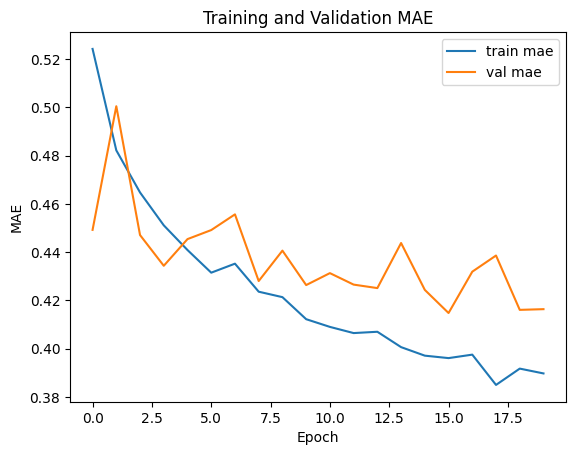

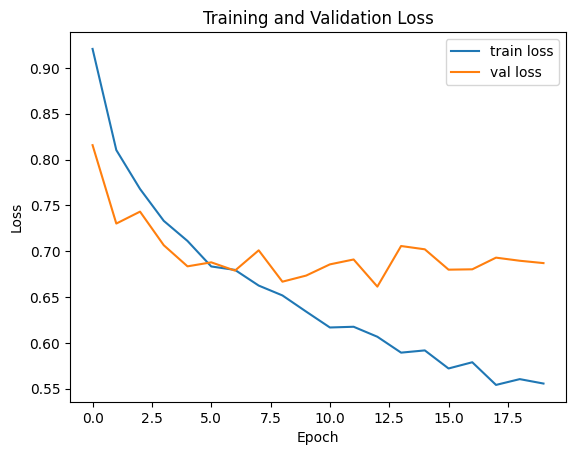

In [103]:
    # Plot MAE
    plt.plot(history.history['mae'], label='train mae')
    plt.plot(history.history['val_mae'], label='val mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.title('Training and Validation MAE')
    plt.show()
    
    # Plot loss
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

In [144]:
tf.keras.backend.clear_session()

In [146]:
model.set_weights(initial_weights)
history = model.fit({'text input': train_text, 'num input': train_metadata}, y_train, validation_data= ({'text input': test_text, 'num input': test_metadata}, y_test), epochs= 50, batch_size= 64)

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - loss: 1.0620 - mae: 0.5777 - val_loss: 0.9309 - val_mae: 0.4747
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - loss: 0.8834 - mae: 0.4902 - val_loss: 0.8039 - val_mae: 0.4945
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - loss: 0.8829 - mae: 0.4941 - val_loss: 0.7887 - val_mae: 0.4867
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - loss: 0.7728 - mae: 0.4625 - val_loss: 0.7474 - val_mae: 0.4837
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - loss: 0.7370 - mae: 0.4575 - val_loss: 0.7796 - val_mae: 0.4744
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - loss: 0.7902 - mae: 0.4660 - val_loss: 0.7315 - val_mae: 0.4819
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 0.7444 - mae: 0.4550 - val_loss: 0.7100 - val_mae: 0.4847
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - loss: 0.7649 - mae: 0.4571 - val_loss: 0.6923 - val_mae: 0.4420
Epoch 9/50
176/176 ━━━━━━━━━━━━━

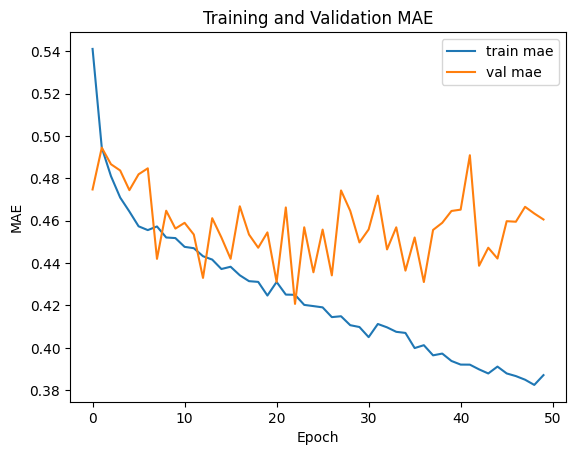

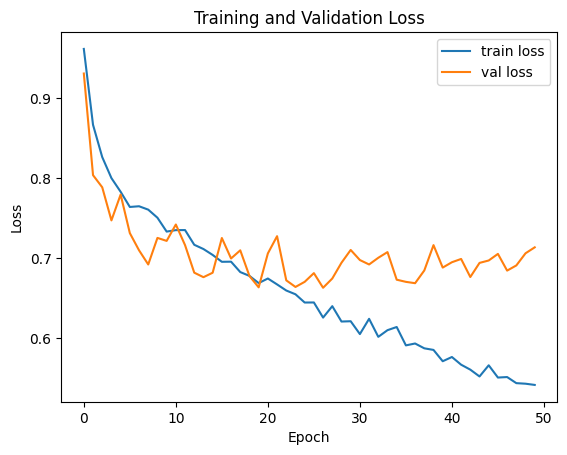

In [147]:
    # Plot MAE
    plt.plot(history.history['mae'], label='train mae')
    plt.plot(history.history['val_mae'], label='val mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.title('Training and Validation MAE')
    plt.show()
    
    # Plot loss
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

## LR Finder, Cyclic LR

In [107]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

In [108]:
class LinearLR(LearningRateSchedule):
    def __init__(self, min_lr= 1e-6, max_lr= 1, steps= 100):
        super().__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps = steps
        self.lr_increment = (max_lr-min_lr)/steps

    def __call__(self, step):
        return self.min_lr + (step*self.lr_increment)

In [109]:
class LossHistory(Callback):
    def on_train_begin(self, logs=None):
        self.lrs = []
        self.losses = []

    def on_train_batch_begin(self, batch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.lrs.append(lr)

    def on_train_batch_end(self, batch, logs=None):
        self.losses.append(logs["loss"])

    def best_lr(self, min_lr, max_lr):
        self.losses.index()

In [110]:
class CyclicLR(Callback):
    """
    Modernized TensorFlow-2.19-compatible Cyclical Learning Rate (CLR) callback.
    Supports 'triangular', 'triangular2', and 'exp_range' policies.
    """

    def __init__(
        self,
        base_lr=0.001,
        max_lr=0.006,
        step_size=2000.,
        mode="triangular",
        gamma=1.,
        scale_fn=None,
        scale_mode="cycle"
    ):
        super().__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma

        # Default scaling functions
        if scale_fn is None:
            if mode == "triangular":
                self.scale_fn = lambda x: 1.
                self.scale_mode = "cycle"
            elif mode == "triangular2":
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = "cycle"
            elif mode == "exp_range":
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = "iterations"
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        # Internal counters
        self.clr_iterations = 0
        self.history = {}

    def _set_lr(self, optimizer, lr_value):
        """Sets the learning rate safely across TF versions."""
        # Preferred attribute
        if hasattr(optimizer, "learning_rate") and isinstance(optimizer.learning_rate, tf.Variable):
            optimizer.learning_rate.assign(lr_value)
        # Fallback for TF SGD
        elif hasattr(optimizer, "_learning_rate"):
            optimizer._learning_rate.assign(lr_value)
        # Last resort
        elif hasattr(optimizer, "lr") and isinstance(optimizer.lr, tf.Variable):
            optimizer.lr.assign(lr_value)
        else:
            raise ValueError("Optimizer has no assignable learning rate variable.")

    def clr(self):
        """Compute the cyclical LR value for the current iteration."""
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)

        if self.scale_mode == "cycle":
            scale = self.scale_fn(cycle)
        else:
            scale = self.scale_fn(self.clr_iterations)

        return self.base_lr + (self.max_lr - self.base_lr) * max(0., (1 - x)) * scale

    def on_train_begin(self, logs=None):
        """Set the initial learning rate."""
        if self.clr_iterations == 0:
            self._set_lr(self.model.optimizer, self.base_lr)
        else:
            self._set_lr(self.model.optimizer, self.clr())

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.clr_iterations += 1

        lr = self.clr()
        self._set_lr(self.model.optimizer, lr)

        # Log for history
        self.history.setdefault("lr", []).append(lr)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

In [111]:
def plot_clr(clr_callback, iterations=10000):
    """
    Plot the learning rate schedule produced by a CyclicLR instance.
    
    Parameters
    ----------
    clr_callback : CyclicLR
        An instance of your CyclicLR callback.
    iterations : int
        Number of training iterations to simulate.
    """

    # Reset counters for clean simulation
    clr_callback.clr_iterations = 0

    lrs = []
    iters = np.arange(iterations)

    for i in iters:
        lr = clr_callback.clr()
        lrs.append(lr)
        clr_callback.clr_iterations += 1

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(iters, lrs)
    plt.title(f"Cyclical Learning Rate Schedule ({clr_callback.mode})")
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.grid(True)
    plt.show()

In [135]:
lr_compile_args = {
    'loss' : 'mse',
    'optimizer' : SGD(learning_rate= LinearLR(min_lr=1e-12, max_lr=1e-10, steps=352)),
    'metrics' : ['mae']
}
logger = LossHistory()

In [136]:
model_noreg.set_weights(initial_weights)
model_noreg.compile(**lr_compile_args)
model_noreg.fit({'text input': train_text, 'num input': train_metadata}, y_train, validation_data= ({'text input': test_text, 'num input': test_metadata}, y_test), epochs= 1, callbacks=[logger], batch_size= 32)

352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - loss: 1.0073 - mae: 0.5435 - val_loss: 0.9820 - val_mae: 0.5562


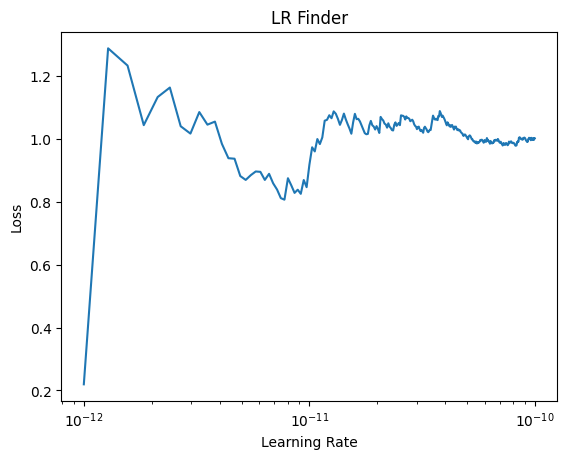

In [137]:
graph_friendly = []
for num in logger.losses:
    if num > 6 or num == np.nan:
        graph_friendly.append(2.6)
    else:
        graph_friendly.append(num)

plt.plot(logger.lrs, graph_friendly)
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("LR Finder")
plt.show()

This graph is indicating to me that perhaps it could be smarter to start with a rate that is way lower

In [138]:
print(logger.losses)

[0.21953460574150085, 1.288369059562683, 1.233537197113037, 1.0439777374267578, 1.1333818435668945, 1.163572072982788, 1.0405112504959106, 1.0170992612838745, 1.0855780839920044, 1.0455548763275146, 1.0552316904067993, 0.9843890070915222, 0.9388166069984436, 0.9372221231460571, 0.8820821642875671, 0.8697590827941895, 0.8850189447402954, 0.8966540098190308, 0.8954110145568848, 0.8697404861450195, 0.8891348838806152, 0.8589487075805664, 0.839076578617096, 0.8118699193000793, 0.8068962097167969, 0.8751084804534912, 0.8523467779159546, 0.8285064101219177, 0.8385953307151794, 0.8255040645599365, 0.8693745136260986, 0.8467147946357727, 0.9185057878494263, 0.9735184907913208, 0.9603856801986694, 0.9997570514678955, 0.983810305595398, 1.004888892173767, 1.0581289529800415, 1.0609424114227295, 1.075501799583435, 1.0660055875778198, 1.0878043174743652, 1.0801124572753906, 1.0641014575958252, 1.0449573993682861, 1.0605239868164062, 1.0806788206100464, 1.0622007846832275, 1.0466570854187012, 1.032

In [118]:
print(logger.losses[7], logger.losses[63])

0.8525524139404297 0.9447265267372131


In [495]:
print("LR Range:", logger.lrs[7], "-", logger.lrs[63])


LR Range: 0.024169184267520905 - 0.19335347414016724


In [496]:
compile_args = {
    'loss' : 'mae',
    'optimizer' : SGD(),
    # 'metrics' : ['mae']
}

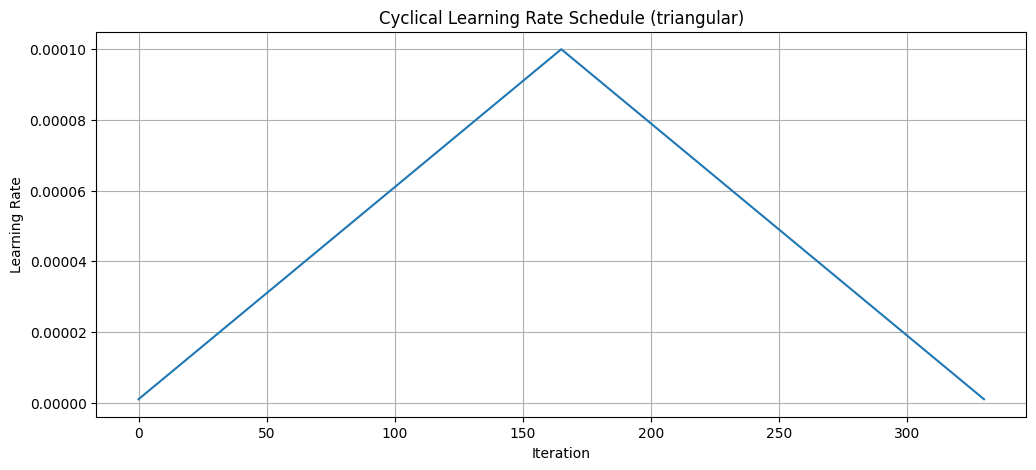

In [497]:
clr = CyclicLR(base_lr= 1e-6, max_lr=1e-4, step_size= 330/2)
plot_clr(clr, iterations=331)

In [498]:
model.set_weights(initial_weights)
model.compile(**compile_args)
model.fit(x= {'text input': train_text, 'num input': train_metadata},
          y= y_train,
          validation_data= ({'text input': test_text, 'num input': test_metadata}, y_test),
          epochs= 20,
          callbacks=[CyclicLR(base_lr= 0.07, max_lr=0.1, step_size= 330/2)],
          batch_size= 128)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 0.4474 - mae: 0.4474 - val_loss: 0.4322 - val_mae: 0.4322
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.4196 - mae: 0.4196 - val_loss: 0.4176 - val_mae: 0.4176
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.4059 - mae: 0.4059 - val_loss: 0.4121 - val_mae: 0.4121
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.3948 - mae: 0.3948 - val_loss: 0.4091 - val_mae: 0.4091
Epoch 5/20
57/88 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.4160 - mae: 0.4160

KeyboardInterrupt: 

In [ ]:
    # Plot MAE
    plt.plot(history.history['mae'], label='train mae')
    plt.plot(history.history['val_mae'], label='val mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.title('Training and Validation MAE')
    plt.show()
    
    # Plot loss
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()